# Advanced Challenge: Randomized Benchmarking

In this challenge, you will implement randomised benchmarking, a protocol to determine the 
average gate fidelity of a quantum process.



In [1]:
from pyquil import Program
from pyquil.api import get_qc, WavefunctionSimulator, local_qvm
from pyquil.gates import *
import numpy as np
import os, inspect, sys
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'tests/')
sys.path.insert(0, 'auxiliary_unitaries/')

from auxiliary_functions.auxiliary_noise import *

%matplotlib inline

make_wf = WavefunctionSimulator()


In [2]:
qc_name = '2q-qvm'
with local_qvm():
    qc = get_qc(qc_name)

qubits = qc.qubits()

In [3]:
#Firstly define the pulse lengths:
    
lengths = [2, 3, 4, 5, 10,15,  20, 25, 30,40, 50,80, 90, 100] 
# lengths = [3] 

## Randomized Benchmarking Protocol: Ideal Case

In [4]:
import random

def random_clifford(circuit, clifford_gates,random_seed):
    
    random.seed(random_seed)
    random_clifford_gate = random.choice(clifford_gates)
    circuit += random_clifford_gate(qubits[0])
    return circuit, random_clifford_gate


Next, define a function to apply a sequence of these random unitaries to the initial state

In [5]:
def random_clifford_sequence(circuit, random_seed, clifford_gates, length):
    
    random_seed = random_seed
    random_gates = []
    for length in range(length):
        circuit, random_clifford_gate = random_clifford(circuit, clifford_gates, random_seed*length)
        random_gates.append(random_clifford_gate)     # keep track of gate, run same sequence
    for gate in random_gates[::-1]: # Invert sequence and apply gates in reverse order (clifford are self-inverse)
        circuit += gate(qubits[0])
    return circuit


Now take that circuit of random cliffords, and measure the fidelity of the final state remaining in the initial state. 

The final state is denoted $|\psi\rangle$, and the initial state was the computational basis state, $|0\rangle$.

Therefore the fidelity is:

\begin{align}
F = |\langle 0 |\psi \rangle|^2 = \Pr(final state = |0\rangle)
\end{align}

So we can estimate this by measuring the qubit a number of times, and counting the number of times we get the '0' ($|0\rangle$) outcome.

# Task:
## Apply a measurement on the single qubit and compute the fidelity.

In [6]:
def compute_fidelity(circuit, random_seed, clifford_gates, length, num_shots):
    circuit = random_clifford_sequence(circuit, random_seed, clifford_gates, length)
    ro = circuit.declare('ro', 'BIT', 2)
    circuit += MEASURE(qubits[0], ro[0])

    circuit.wrap_in_numshots_loop(num_shots)
    executable = qc.compile(circuit)
    results = qc.run(executable)
    prob_zero = list(results).count([0])/num_shots 

    
    return prob_zero


# circuit = Program()
# clifford_gates = [H, Z, X]

# random_seed = 1
# length = 4
# num_shots = 1000

# fidelity = compute_fidelity(circuit, random_seed, clifford_gates, length, num_shots)

# print(fidelity)

In [7]:
def compute_avg_fidelity(random_seeds, clifford_gates, lengths, num_shots, noise=False, p=0.1):
    average_fidelities = np.zeros(len(lengths)) # Array of average fidelities for each sequence length
    
    num_seq_repeats = len(random_seeds)
    for length in range(len(lengths)):
        fidelity = np.zeros(num_seq_repeats)
        seq_len = lengths[length]
        for repeat in range(num_seq_repeats):
            circuit = Program()
            fidelity[repeat] = compute_fidelity(circuit, repeat, clifford_gates, seq_len, num_shots)
        average_fidelities[length] = (1/num_seq_repeats)*np.sum(fidelity)
    
    return average_fidelities

# sequence_length_repeats = 10 # Number of repeats of a particular sequence length

# random_seeds = np.arange(0, 10, sequence_length_repeats)
# num_shots = 10
# clifford_gates = [Z, X]

# average_fidelities = compute_avg_fidelity(random_seeds, clifford_gates, lengths, num_shots)
# print('The sequence lengths are:', lengths)
# print('\nThe average fidelities are:' , average_fidelities)

Next, we can plot the average fidelity as a function of the quantum circuit sequence lengths.
In the ideal case (that you have just done), clearly the average fidelity should be the same regardless of the sequence length.

When the inverse sequence of gates was applied, there was no noise, so effectively nothing happened to the $|0\rangle$ state; it returned to the $\0\rangle$ state **every** time, and the fidelity should always be $1$.

Increasing the length of the circuit does not affect this.

We can plot the average fidelities as a function of the sequence lengths (this is a trivial task in this case, but it will become relevant shortly.)

In [8]:
# plt.plot(lengths, average_fidelities)

Next, we must define 'noisy' gates to benchmark.

These will be noisy versions of the perfect clifford gates we used above.

For example, imagine our sequence of (one) random cliffords was $X$ applied the the input state:

\begin{align}
X|0\rangle
\end{align}

The corresponding density matrix would be (in the perfect case):

\begin{align}
\rho_{ideal} = X|0\rangle\langle 0|X
\end{align}

Now we can use the density matrix formalism to describe an ***error channel***. Firstly we can examine what is called a '*dephasing*' error channel, which means an erroneous phase error is applied to the state with some probability.

In other words, after we thought we had applied the $X$ gates to the state, because of the presence of this error channel, the *actual* state will be the correct state, with some probability, $p$, and some other state (with an error), with the remaining probability (1-p):

\begin{align}
\rho_{noisy} = \begin{cases}
\rho =  X|0\rangle\langle 0|X  &\text{ with some probability } p\\
Z\rho Z = ZX|0\rangle\langle 0|XZ &\text{ with probability } 1-p
\end{cases}
\end{align}

We can represent this by a *statistical mixture of these two possibilities*:
\begin{align}
\rho_{noisy} = \mathcal{E}_{dephase}(\rho_{ideal}) =  p\rho_{ideal}+ (1-p)Z\rho_{ideal} Z = pX|0\rangle\langle 0|X+ (1-p)ZX|0\rangle\langle 0|XZ 
\end{align}

where $\mathcal{E}_{dephase}(\rho_{ideal})$ is the dephasing error channel applied to the *ideal* state, $\rho_{ideal}$.

In the simplest example, we can assume this **same** error channel, $\mathcal{E}_{dephase}$  with the **same** error strength, $p$, is applied after ***every*** random gate. 

We can then use apply the same protocol as above with the noisy clifford gates (with this dephasing error model)
to get an idea of the average fidelity of the process.

*Hint: This should **not** be $1$ for all sequence lengths in this case, we should see the fidelity decay as longer sequences are applied $\rightarrow$ the effect of noise compounds after each gate.*

Of course, when using the simulator, we must **artificially** define our noisy gates. We will directly use the example [here](http://docs.rigetti.com/en/stable/noise.html) to create the dephasing channel.

This uses the idea of Kraus maps, which is a generalisation of the above, for our purposes, a kraus map is just defined by a matrix, for example $Z$ or the identity $I$ (which would be the ideal case).

The above equation can be written as:

\begin{align}
\rho_{noisy} = \mathcal{E}_{dephase}(\rho_{ideal}) =  (\sqrt{p}\mathbb{I})(\rho_{ideal})(\sqrt{p}\mathbb{I})+ \sqrt{(1-p)}Z\rho_{ideal} \sqrt{(1-p)}Z 
\end{align}


Now we must apply this channel to the target gate, which must be done for each of the Clifford gates.
The example for the X gate is below:

*Note: This is only done for this example, you will not use the program 'test_circuit' afterwards.*

In [9]:
import random

def random_clifford_noisy_sequence(noisy_clifford_gates, length, p):
    '''Generates a sequence of random gates from the set of noiy gates of length p'''  
    random_gate_sequence = []
    for operation in range(length):

        random_clifford_gate = random.choice(noisy_clifford_gates)
        random_gate_sequence.append(random_clifford_gate)     # keep track of randomly generated gate

    return random_gate_sequence


In [10]:
def apply_random_noisy_gate_sequence(circuit, random_gate_sequence, p):
    '''Generates a sequence of random operations'''

    for gate in random_gate_sequence:
        circuit += gate(p)(0)

    for gate in random_gate_sequence[::-1]: # Invert sequence and apply gates in reverse order (clifford are self-inverse)
        circuit += gate(p)(qubits[0])
        
    return circuit


In [15]:
def compute_fidelity_noisy(circuit, random_gate_sequence, length, num_shots, p):
    
    circuit = apply_random_noisy_gate_sequence(circuit, random_gate_sequence, p)
    print(circuit)
    ro = circuit.declare('ro', 'BIT', 2)
    circuit += MEASURE(qubits[0], ro[0])
#     print(circuit)
    circuit.wrap_in_numshots_loop(num_shots)
    executable = qc.compile(circuit)
    results = qc.run(executable)
    
    prob_zero = list(results).count([0])/num_shots 

    return prob_zero

We can load the sequence of predefined noisy clifford gates from an auxiliary function:

In [16]:
def compute_avg_fidelity_noisy(lengths, num_shots, num_seq_repeats, p=0.1):
    
    average_fidelities = np.zeros(len(lengths)) # Array of average fidelities for each sequence length
    
    for length in range(len(lengths)):
        noisy_cliffords, noisy_cliffords_defn = define_noisy_cliffords(p)
        # Generate a sequence of noisy gates
#         [NOISY_X, NOISY_H, NOISY_Z, NOISY_Y] = noisy_cliffords # List of available noisy gates
        random_gate_seq = random_clifford_noisy_sequence(noisy_cliffords, length, p) 

        fidelity = np.zeros(num_seq_repeats)
        seq_len = lengths[length]
        
        for repeat in range(num_seq_repeats):
            circuit = Program()
            # Define noisy cliffords so they can be used in the circuit
            circuit = add_noisy_gates_to_circ(circuit, noisy_cliffords_defn, p)
            
            fidelity[repeat] = compute_fidelity_noisy(circuit, random_gate_seq, length, num_shots, p)
            print('Fidelity for run, ', repeat, 'is', fidelity[repeat])
        average_fidelities[length] = (1/num_seq_repeats)*np.sum(fidelity)
        print('Average fidelity for length: \n', length,'\n is:\n', average_fidelities[length])
    return average_fidelities




num_seq_repeats = 10# Number of repeats of a particular sequence length

# random_seeds = np.arange(0, 100, sequence_length_repeats)
# print(random_seeds)
num_shots = 100
# clifford_gates = [Z, X]

average_fidelities = compute_avg_fidelity_noisy( lengths, num_shots, num_seq_repeats)
print('The sequence lengths are:', lengths)
print('\nThe average fidelities are:' , average_fidelities)


DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p - %p
    1 + %p - %p, 0

DEFG

Fidelity for run,  5 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  1 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  7 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  3 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  8 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  3 is 0.04
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  9 is 0.02
Average fidelity for length: 
 3 
 is:
 0.05500000000000001
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
  

Fidelity for run,  5 is 0.1
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  0 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  5 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  1 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  7 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  2 is 0.87
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  8 is 0.79
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  2 is 0.02
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  7 is 0.02
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  1 is 0.93
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  5 is 0.94
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  9 is 0.97
Average fidelity for length: 
 9 
 is:
 0.9380000000000002
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
   

Fidelity for run,  3 is 0.07
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  7 is 0.05
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  1 is 0.84
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  5 is 0.83
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  9 is 0.83
Average fidelity for length: 
 11 
 is:
 0.8240000000000001
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
  

Fidelity for run,  3 is 0.64
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  7 is 0.59
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p 

Fidelity for run,  1 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  5 is 1.0
DEFGATE NOISY_X(%p):
    0, 1 - %p
    1 - %p, 0

DEFGATE NOISY_H(%p):
    0.7071067811865475, 0.7071067811865475*(1 - 2*%p)
    0.7071067811865475*(1 - 2*%p), 0.7071067811865475

DEFGATE NOISY_Z(%p):
    1 - %p + %p, 0
    0, -1 + %p - %p

DEFGATE NOISY_Y(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_I(%p):
    1 + %p - %p, 0
    0, 1 + %p - %p

DEFGATE NOISY_iZ(%p):
    i*(1 - %p + %p), 0
    0, i*(-1 + %p - %p)

DEFGATE NOISY_iH(%p):
    0.7071067811865475i, 0.7071067811865475i*(1 - 2*%p)
    0.7071067811865475i*(1 - 2*%p), 0.7071067811865475i

DEFGATE NOISY_minusiH(%p):
    -0.7071067811865475i, -0.7071067811865475i*(1 - 2*%p)
    -0.7071067811865475i*(1 - 2*%p), -0.7071067811865475i

DEFGATE NOISY_iX(%p):
    0.0, i*(1 - %p + %p)
    i*(1 - %p + %p), 0.0

DEFGATE NOISY_minusiX(%p):
    0.0, -i*(1 - %p + %p)
    -i*(1 - %p + %p), 0.0

DEFGATE NOISY_iY(%p):
    0, -i*(1 - 2*%p)
    i*(1 - 2*%p), 0

DEFGATE NOISY_minusiY(%p):
    0, 1 + %p -

Fidelity for run,  9 is 1.0
Average fidelity for length: 
 13 
 is:
 1.0
The sequence lengths are: [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 80, 90, 100]

The average fidelities are: [1.    1.    1.    0.055 0.056 1.    1.    0.805 0.036 0.938 0.052 0.824
 0.613 1.   ]


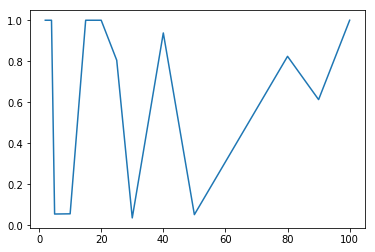

In [17]:
plt.plot(lengths, average_fidelities)